[*********************100%%**********************]  1 of 1 completed


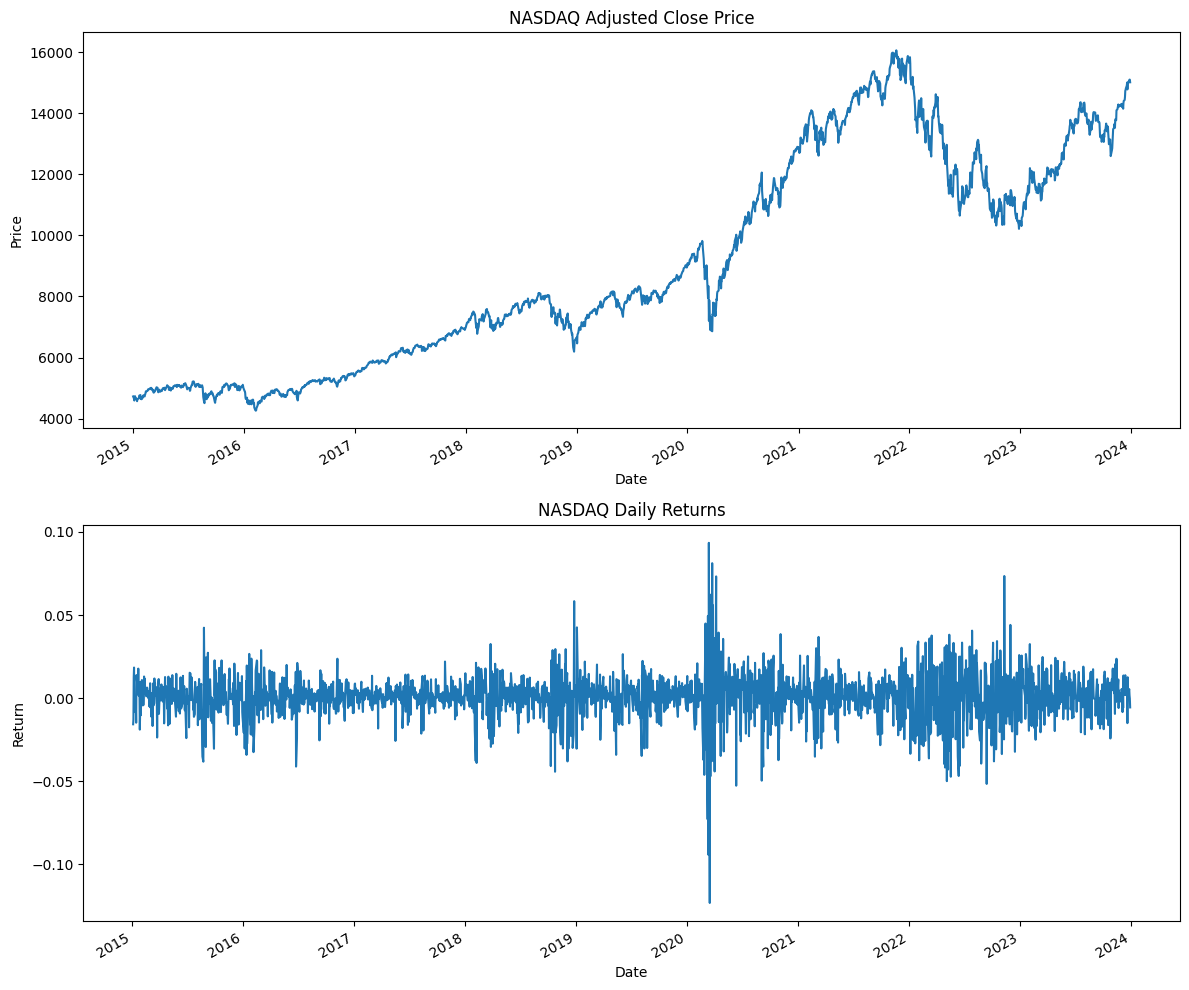

ADF Statistic: -15.61620113508557
p-value: 1.754792015680671e-28
Critical Values: {'1%': -3.43325450880204, '5%': -2.862823135013053, '10%': -2.567453072861103}


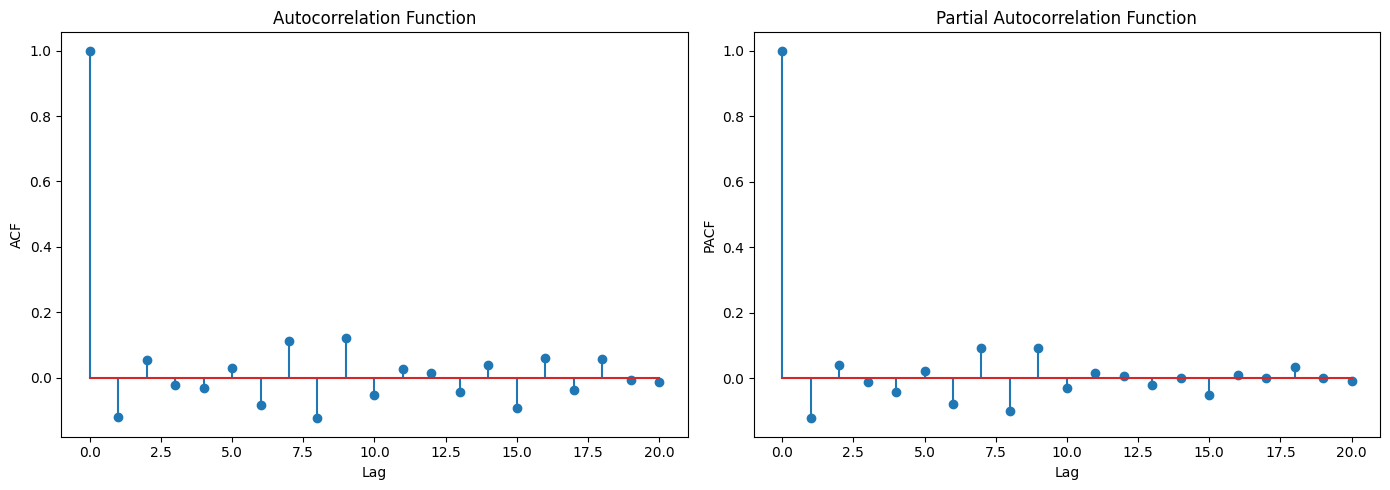

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller, acf, pacf
import yfinance as yf

# Step 1: Download NASDAQ historical data
nasdaq = yf.download('^IXIC', start='2015-01-01', end='2023-12-31')

# Calculate daily returns
nasdaq['Return'] = nasdaq['Adj Close'].pct_change().dropna()

# Plot the NASDAQ index and returns
fig, ax = plt.subplots(2, 1, figsize=(12, 10))

# Plotting NASDAQ adjusted close price
nasdaq['Adj Close'].plot(ax=ax[0])
ax[0].set_title('NASDAQ Adjusted Close Price')
ax[0].set_ylabel('Price')

# Plotting NASDAQ returns
nasdaq['Return'].plot(ax=ax[1])
ax[1].set_title('NASDAQ Daily Returns')
ax[1].set_ylabel('Return')

plt.tight_layout()
plt.show()

# Step 2: Perform Augmented Dickey-Fuller test
adf_result = adfuller(nasdaq['Return'].dropna())

print('ADF Statistic:', adf_result[0])
print('p-value:', adf_result[1])
print('Critical Values:', adf_result[4])

# Step 3: Calculate ACF and PACF
lag_acf = acf(nasdaq['Return'].dropna(), nlags=20)
lag_pacf = pacf(nasdaq['Return'].dropna(), nlags=20)

# Plot ACF and PACF
fig, ax = plt.subplots(1, 2, figsize=(14, 5))

# Plot ACF
ax[0].stem(lag_acf)
ax[0].set_title('Autocorrelation Function')
ax[0].set_xlabel('Lag')
ax[0].set_ylabel('ACF')

# Plot PACF
ax[1].stem(lag_pacf)
ax[1].set_title('Partial Autocorrelation Function')
ax[1].set_xlabel('Lag')
ax[1].set_ylabel('PACF')

plt.tight_layout()
plt.show()


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

Mean Abnormal Return: 0.00016717841638035284
T-statistic: 0.09730853492311506


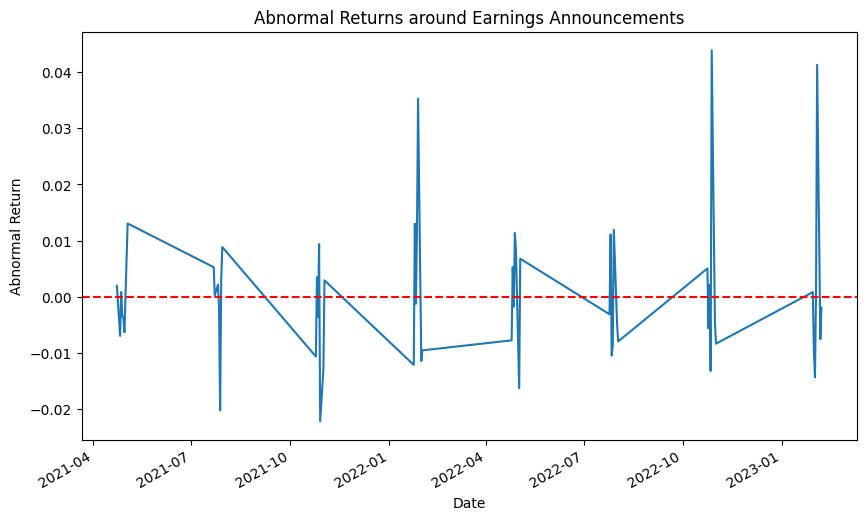

In [2]:
# Therefore, NASDAQ holds the weak form EMH.
# Event study of AAPL announcement to test whether NASDAQ holds the semi-strong form EMH.

import yfinance as yf
import pandas as pd
import numpy as np
from datetime import timedelta
import statsmodels.api as sm
import matplotlib.pyplot as plt

# Step 1: Collect Data
# Download historical stock prices for Apple and NASDAQ
apple = yf.download('AAPL', start='2015-01-01', end='2023-12-31')
nasdaq = yf.download('^IXIC', start='2015-01-01', end='2023-12-31')

# Example earnings announcement dates for Apple
earnings_dates = [
    '2023-02-02', '2022-10-27', '2022-07-28', '2022-04-28',
    '2022-01-27', '2021-10-28', '2021-07-27', '2021-04-28'
]
earnings_dates = pd.to_datetime(earnings_dates)

# Step 2: Calculate Returns
apple['Return'] = apple['Adj Close'].pct_change().dropna()
nasdaq['Return'] = nasdaq['Adj Close'].pct_change().dropna()

# Step 3: Calculate Expected Returns using CAPM
# Merge returns into a single DataFrame
returns = pd.merge(apple[['Return']], nasdaq[['Return']], left_index=True, right_index=True, suffixes=('_AAPL', '_NASDAQ'))

# Add constant for OLS regression
returns['Constant'] = 1

# Run regression to find alpha and beta
model = sm.OLS(returns['Return_AAPL'].dropna(), returns[['Return_NASDAQ', 'Constant']].dropna()).fit()
alpha, beta = model.params['Constant'], model.params['Return_NASDAQ']

# Calculate expected returns
returns['Expected_Return'] = alpha + beta * returns['Return_NASDAQ']

# Calculate abnormal returns
returns['Abnormal_Return'] = returns['Return_AAPL'] - returns['Expected_Return']

# Step 4: Perform Event Study
event_window = 5
abnormal_returns = []

for date in earnings_dates:
    start_date = date - timedelta(days=event_window)
    end_date = date + timedelta(days=event_window)
    event_abnormal_returns = returns.loc[start_date:end_date]['Abnormal_Return']
    abnormal_returns.append(event_abnormal_returns)

# Combine abnormal returns
abnormal_returns = pd.concat(abnormal_returns)

# Step 5: Statistical Tests
mean_abnormal_return = abnormal_returns.mean()
t_stat = mean_abnormal_return / (abnormal_returns.std() / np.sqrt(len(abnormal_returns)))

print('Mean Abnormal Return:', mean_abnormal_return)
print('T-statistic:', t_stat)

# Plotting the Abnormal Returns
plt.figure(figsize=(10, 6))
abnormal_returns.plot()
plt.axhline(0, color='red', linestyle='--')
plt.title('Abnormal Returns around Earnings Announcements')
plt.xlabel('Date')
plt.ylabel('Abnormal Return')
plt.show()


[*********************100%%**********************]  5 of 5 completed

        Weight
BA    0.199672
MSFT  0.236538
AAPL  0.100000
AMZN  0.100000
GOOG  0.363790


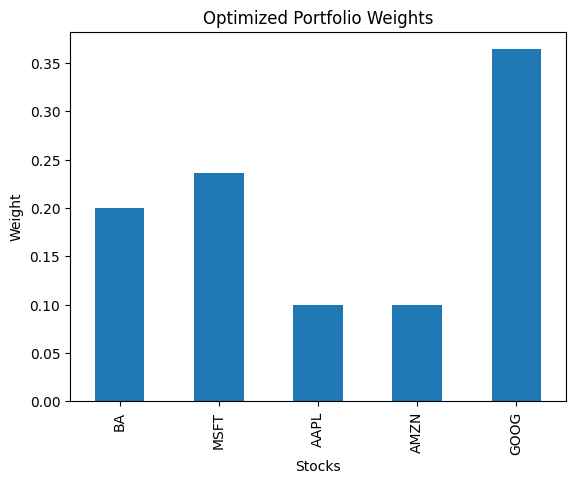

In [5]:
import numpy as np
import pandas as pd
import yfinance as yf
from scipy.optimize import minimize
import matplotlib.pyplot as plt

# Define the stock tickers
tickers = ['BA', 'MSFT', 'AAPL', 'AMZN', 'GOOG']

# Download historical data
data = yf.download(tickers, start='2015-01-01', end='2023-12-31')['Adj Close']

# Calculate daily returns
returns = data.pct_change().dropna()

# Define the portfolio optimization function
def portfolio_performance(weights, mean_returns, cov_matrix):
    returns = np.sum(mean_returns * weights) * 252
    std = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights))) * np.sqrt(252)
    return std, returns

def neg_sharpe_ratio(weights, mean_returns, cov_matrix, risk_free_rate=0.01):
    p_var, p_ret = portfolio_performance(weights, mean_returns, cov_matrix)
    return -(p_ret - risk_free_rate) / p_var

def optimize_portfolio(mean_returns, cov_matrix):
    num_assets = len(mean_returns)
    args = (mean_returns, cov_matrix)
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bound = (0.1, 1)
    bounds = tuple(bound for asset in range(num_assets))
    result = minimize(neg_sharpe_ratio, num_assets * [1. / num_assets], args=args,
                      method='SLSQP', bounds=bounds, constraints=constraints)
    return result

# Calculate mean returns and covariance matrix
mean_returns = returns.mean()
cov_matrix = returns.cov()

# Optimize portfolio
opt_result = optimize_portfolio(mean_returns, cov_matrix)
opt_weights = opt_result.x

# Display optimized weights
portfolio_weights = pd.DataFrame(opt_weights, index=tickers, columns=['Weight'])
print(portfolio_weights)

# Plot optimized weights
portfolio_weights.plot(kind='bar', legend=False)
plt.title('Optimized Portfolio Weights')
plt.xlabel('Stocks')
plt.ylabel('Weight')
plt.show()
